In [1]:
from collections import Counter
import random

import numpy as np
from data_manipulation.reading_util import load_all_sub_classes
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

import os
from dotenv import load_dotenv
from data_manipulation.reading_util import load_non_enz_esm2
from metrics_helper_funcs.validation_tools import plot_bootstrapped_score, plot_confiusion_matrix, calculate_micro_f1, calculate_accuracy, calculate_macro_f1

load_dotenv()



2023-10-31 10:12:33.711272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 10:12:35.121118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

In [2]:
comp_ec_to_label = {
    "1.1": 1,
    "1.2": 2,
    "1.3": 3,
    "1.4": 4,
    "1.5": 5,
    "1.6": 6,
    "1.7": 7,
    "1.8": 8,
    "1.11": 9,
    "1.12": 10,
    "1.13": 11,
    "1.14": 12,
    "1.15": 13,
    "1.16": 14,
    "1.17": 15,
    "1.18": 16,
    "1.21": 17,
    "1.10": 18,
    "1.20": 18,
    "1.23": 18,
    "1.97": 18,
    "2.1": 19,
    "2.3": 20,
    "2.4": 21,
    "2.5": 22,
    "2.6": 23,
    "2.7": 24,
    "2.8": 25,
    "2.2": 26,
    "2.9": 26,
    "2.10": 26,
    "3.1": 27,
    "3.2": 28,
    "3.4": 29,
    "3.5": 30,
    "3.6": 31,
    "3.3": 32,
    "3.7": 32,
    "3.8": 32,
    "3.9": 32,
    "3.11": 32,
    "3.13": 32,
    "4.1": 33,
    "4.2": 34,
    "4.3": 35,
    "4.4": 36,
    "4.6": 37,
    "4.99": 38,
    "4.7": 38,
    "4.5": 38,
    "5.1": 39,
    "5.2": 40,
    "5.3": 41,
    "5.4": 42,
    "5.5": 43,
    "5.6": 44,
    "5.7": 44,
    "5.99": 44,
    "6.1": 45,
    "6.2": 46,
    "6.3": 47,
    "6.5": 48,
    "6.4": 48,
    "6.6": 48,
    "7.1": 49,
    "7.2": 50,
    "7.3": 51,
    "7.4": 51,
    "7.5": 51,
    "7.6": 51,
}

comp_label_to_ec = {
    1: "1.1" ,
    2: "1.2" ,
    3: "1.3" ,
    4: "1.4" ,
    5: "1.5" ,
    6: "1.6" ,
    7: "1.7" ,
    8: "1.8" ,
    9: "1.11" ,
    10: "1.12" ,
    11: "1.13" ,
    12: "1.14" ,
    13: "1.15" ,
    14: "1.16" ,
    15: "1.17" ,
    16: "1.18" ,
    17: "1.21" ,
    18: "1.10_20_23_97" ,
    19: "2.1" ,
    20: "2.3" ,
    21: "2.4" ,
    22: "2.5" ,
    23: "2.6" ,
    24: "2.7" ,
    25: "2.8" ,
    26: "2.2_9_19" ,
    27: "3.1" ,
    28: "3.2" ,
    29: "3.4" ,
    30: "3.5" ,
    31: "3.6" ,
    32: "3.3_7_8_9_11_13" ,
    33: "4.1" ,
    34: "4.2" ,
    35: "4.3" ,
    36: "4.4" ,
    37: "4.6" ,
    38: "4.99_7_5" ,
    39: "5.1" ,
    40: "5.2" ,
    41: "5.3" ,
    42: "5.4" ,
    43: "5.5" ,
    44: "5.6_7_99" ,
    45: "6.1" ,
    46: "6.2" ,
    47: "6.3" ,
    48: "6.5_4_6" ,
    49: "7.1" ,
    50: "7.2" ,
    51: "7.3_4_5_6" ,
}


In [3]:
# Random level 2 pred
def random_level_2(y):

    count_dict = Counter(y)
    predictions = []

    for key in count_dict.keys():
        count_dict[key] /= len(y)

    for _ in y:
        predicted_label = random.choices(list(count_dict.keys()), weights=count_dict.values())[0]
        predictions.append(predicted_label)
    
    return np.array(predictions)



In [4]:
def validate_on_test_data(path_to_test_csv: str, path_to_test_esm2: str, 
                          path_to_non_ez_fasta: str, path_to_non_ez_esm2: str, 
                          path_to_multiclass_model, path_to_binaryclass_model):

    print("\n\n\t\t\t\033[34m[ LOADING DATA AND MODELS ]\033[0m\n\n\t\t\t")
    # Load model and test data
    multiclass__model = tf.keras.models.load_model(path_to_multiclass_model)
    binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)


    X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2=path_to_test_esm2, path_to_enzyme_csv=path_to_test_csv, allowed_labels=comp_ec_to_label)

    # Load non_enzymes
    X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=path_to_non_ez_fasta,
                                                     non_enzymes_esm2_path=path_to_non_ez_esm2)
    del _
    y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])
    
    # Combine data
    X = np.vstack((X_enzymes, X_non_enzymes))
    y = np.hstack((y_enzymes, y_non_enzymes))
    del X_enzymes
    del X_non_enzymes
    del y_enzymes


    # Plot input data
    y_sorted = y.copy()
    y_sorted.sort()

    y_ec_classes = [0 for i in range(len(y_non_enzymes))]
    
    del y_non_enzymes
    
    y_ec_classes.extend([comp_label_to_ec[label] for label in y_sorted if label != 0])

    print("\n\n\t\t\t\033[34m[ PLOTTING INPUT DISTRIBUTION ]\033[0m\n\n\t\t\t")
    
    sns.set()
    sns.set(style="whitegrid")
    sns.set_palette("Set2")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set(font_scale=0.8)  # Adjust font size as needed

    countplot = sns.countplot(x=y_ec_classes)
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

    # Add labels and title
    plt.title("Preprocessed labels for multiclass FNN")
    plt.xlabel("Labels")
    plt.ylabel("Count")

    # Show the plot
    plt.show()

    print("\n\n\t\t\t\033[34m[ MAKING PREDICTIONS ]\033[0m\n\n\t\t\t")

    complete_predictions = []
    complete_y_true = []

    binary_predictions = binaryclass_model.predict(X) > 0.5

    X_to_predict_multiclass = []
    y_multiclass_true = []

    for index, prediction in enumerate((binary_predictions).astype(int)):
        if prediction == 1:
            X_to_predict_multiclass.append(X[index])
            y_multiclass_true.append(y[index])
        else:
            complete_predictions.append(int(prediction))
            complete_y_true.append(y[index])




    # Get multiclass predictions
    y_multiclass_pred = np.argmax(multiclass__model.predict(np.array(X_to_predict_multiclass)), axis=-1)
    y_multiclass_pred = [label+1 for label in y_multiclass_pred]
    complete_predictions.extend(y_multiclass_pred)
    complete_predictions = np.array(complete_predictions) # convert to np array
    y_pred = complete_predictions

    # Correctly concatenate actual labels for validation
    complete_y_true.extend(y_multiclass_true)
    y_true = complete_y_true
    y_true = np.array(y_true) # convert to np array

    report = classification_report(y_true, y_pred)
    print(report)


    print("\n\n\t\t\t\033[34m[ MAKING BASELINE PREDICTION ]\033[0m\n\n\t\t\t")
    
    random_baseline_binary_predictions = np.random.choice(y, len(y))
    
    y_multiclass_random_true = []
    complete_random_predictions = []
    complete_y_true_random = []

    for index, prediction in enumerate(random_baseline_binary_predictions.astype(int)):
        if prediction == 1:
            y_multiclass_random_true.append(y[index])
        else:
            complete_random_predictions.append(int(prediction))
            complete_y_true_random.append(y[index])
            
    # get random multiclass predictions
    y_random_predictions_multiclass = random_level_2(y_multiclass_true)
    # y_random_predictions_multiclass = [label+1 for label in y_random_predictions_multiclass]
    complete_random_predictions.extend(y_random_predictions_multiclass)
    complete_random_predictions = np.array(complete_random_predictions) # all predictions (Binary and multiclass)
    y_pred_random = complete_random_predictions
    
    # concatenate y_true
    complete_y_true_random.extend(y_multiclass_true)
    y_true_random = np.array(complete_y_true_random) # all actual labels for validation

    print(classification_report(y_true_random, y_pred_random))
    
   
    print("\n\n\t\t\t\033[34m[ PLOTTING CONFUSION MATRIX ]\033[0m\n\n\t\t\t")

    plot_confiusion_matrix(y_true=y_true, y_pred=y_pred, plot_title="Level 2 FNN",hide_inner_labels=True, lable_size=10)
    plot_confiusion_matrix(y_true=y_true_random, y_pred=y_pred_random, plot_title="Level 2 Random Baseline",hide_inner_labels=True, lable_size=10)

    print("\n\n\t\t\t\033[34m[ PLOTTING SCORES ]\033[0m\n\n\t\t\t")

    plot_bootstrapped_score(y_trues=[y_true, y_true_random], y_preds=[y_pred, y_pred_random], scoring_funcs=[calculate_micro_f1,calculate_macro_f1, calculate_accuracy], model_names=["FNN Pipeline Level 2", "Random Baseline Level 2"])
    

In [5]:

def validate_on_test_data1(X, y, path_to_multiclass_model, path_to_binaryclass_model):
    
    # Load model and test data
    multiclass__model = tf.keras.models.load_model(path_to_multiclass_model)
    binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)


    print("\n\n\t\t\t\033[34m[ MAKING PREDICTIONS ]\033[0m\n\n\t\t\t")

    complete_predictions = []
    complete_y_true = []

    binary_predictions = binaryclass_model.predict(X) > 0.5
    
    X_to_predict_multiclass = []
    y_multiclass_true = []

    for index, prediction in enumerate((binary_predictions).astype(int)):
        if prediction == 1:
            X_to_predict_multiclass.append(X[index])
            y_multiclass_true.append(y[index])
        else:
            complete_predictions.append(int(prediction))
            complete_y_true.append(y[index])
            
    complete_y_true.extend(y_multiclass_true)
    y_true = complete_y_true
            


    multiclass_y_pred = np.argmax(multiclass__model.predict(np.array(X_to_predict_multiclass)), axis=-1)
    multiclass_y_pred = [label+1 for label in multiclass_y_pred]
    complete_predictions.extend(multiclass_y_pred)
    

    y_true = np.array(y_true)
    complete_predictions = np.array(complete_predictions)
    
    report = classification_report(y_true, complete_predictions)
    print(report)

    # plot_score(y_true, complete_predictions)

    print("\n\n\t\t\t\033[34m[ PLOTTING CONFUSION MATRIX ]\033[0m\n\n\t\t\t")
    
    plot_confiusion_matrix(y_true=y_true, y_pred=complete_predictions, plot_title="test",hide_inner_labels=True, lable_size=10)

    print("\n\n\t\t\t\033[34m[ PLOTTING SCORES ]\033[0m\n\n\t\t\t")
    
    plot_bootstrapped_score(y_trues=[y_true], y_preds=[complete_predictions], scoring_funcs=[calculate_micro_f1, calculate_macro_f1, calculate_accuracy], model_names=["Multiclass FNN Pipeline"])



In [6]:
bin_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_binary_opt_S30_v2_default_sampled_weighted.keras"


mul_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/CNN_S30_weighted_opt_v2.keras"

emb_path = os.getenv("ESM2_ENZYMES_SPLIT_10")
csv_path = os.getenv("CSV10_ENZYMES")

fasta_path = os.getenv("FASTA_NON_ENZYMES")
emb_non_ez_path = os.getenv("ESM2_NON_ENZYMES")



			[ LOADING DATA AND MODELS ]

			
LOG:
 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split10.csv
LOG:
 12 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split10.csv
LOG:
 166 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split10.csv
LOG:
 181 entries will be ignored
LOG:
 Data loaded in: 0.787 min
LOG:
 ESM2 of enzymes: 7212
LOG:
 Labels of enzymes: 7212
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG:
 17 Sequences with aa U in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG:
 2138 non enzymes are longer than 1022 cutoff
LOG:
 2155 entries will be ignored
LOG:
 Non Enzymes data loaded in: 4.348 min
LOG:
 ESM2 of non enzymes: 39502
LOG:
 Labels of non enzymes: 39502


			[ PLOTTING INPUT DISTRIBUTION ]

			


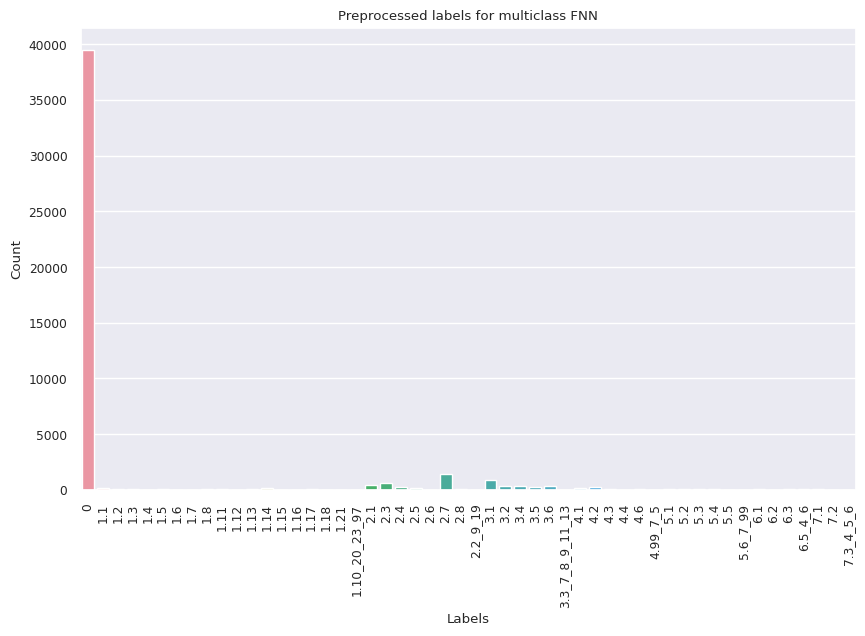



			[ MAKING PREDICTIONS ]

			
292/292 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     39502
           1       0.63      0.86      0.73       140
           2       0.70      0.96      0.81        52
           3       0.58      0.86      0.69        96
           4       0.32      0.74      0.45        23
           5       0.50      0.75      0.60        61
           6       0.28      0.94      0.43        16
           7       0.52      0.71      0.60        31
           8       0.49      0.80      0.61        61
           9       0.73      0.86      0.79        42
          10       0.41      0.76      0.53        17
          11       0.65      0.78      0.71        54
          12       0.50      0.86      0.64       181
          13       0.44      0.89      0.59        18
          14       0.62      0.84      0.71        19
          15       0.72      0.82      0.77    

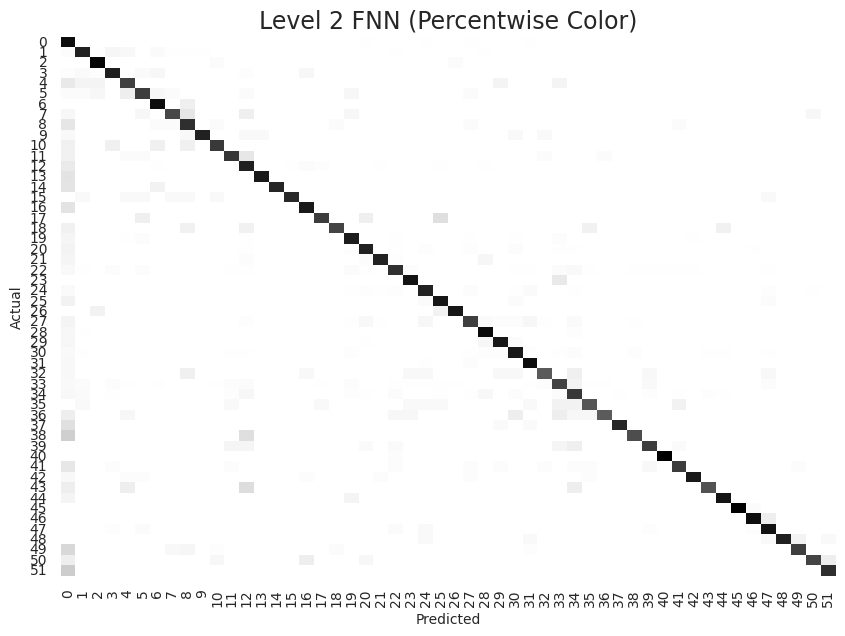

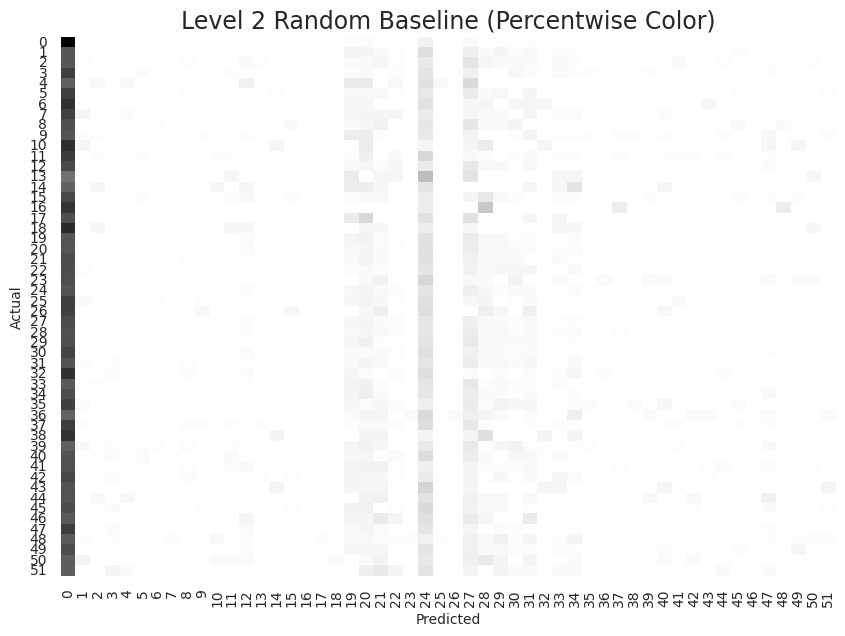



			[ PLOTTING SCORES ]

			
                     Model          Metric  Mean Score       SE      CI_0  \
0  Multiclass FNN Pipeline  Micro F1-Score      0.9240  0.00120  0.922036   
1  Multiclass FNN Pipeline  Macro F1-Score      0.6710  0.00810  0.655258   
2  Multiclass FNN Pipeline        Accuracy      0.9240  0.00120  0.922100   
0          Random Baseline  Micro F1-Score      0.6180  0.00200  0.613779   
1          Random Baseline  Macro F1-Score      0.0251  0.00085  0.023491   
2          Random Baseline        Accuracy      0.6180  0.00210  0.613743   

       CI_1  
0  0.926810  
1  0.686705  
2  0.926789  
0  0.621722  
1  0.026796  
2  0.621757  


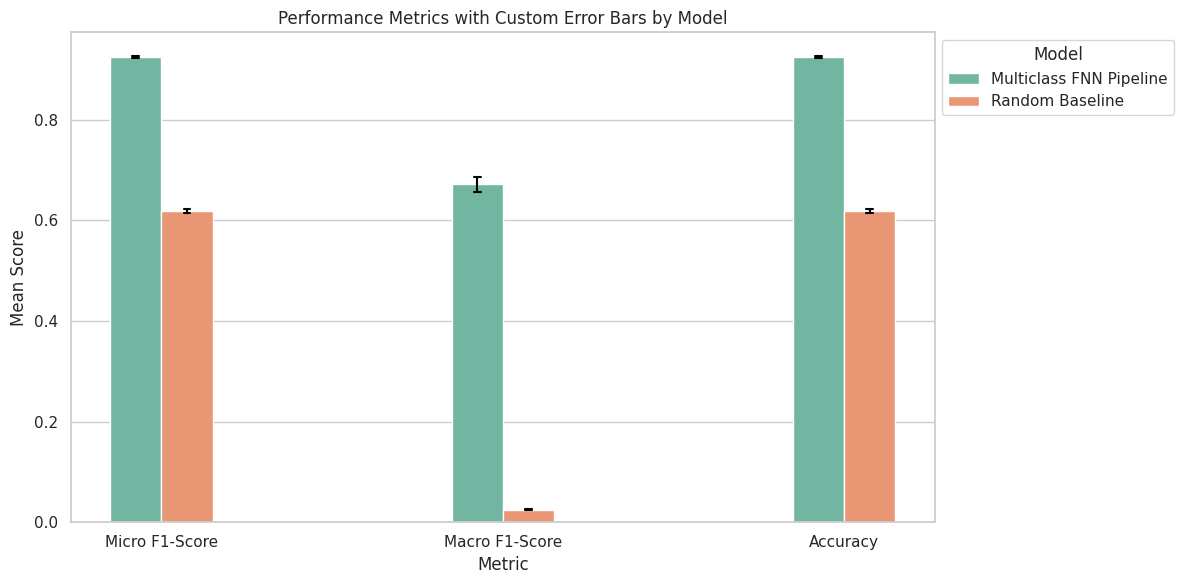

In [7]:
validate_on_test_data(path_to_test_csv=csv_path,
                      path_to_test_esm2=emb_path,
                      path_to_non_ez_esm2=emb_non_ez_path,
                      path_to_non_ez_fasta=fasta_path,
                      path_to_binaryclass_model=bin_class_path,
                  path_to_multiclass_model=mul_class_path)